In [1]:
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import json
import gensim
import matplotlib.pyplot as plt

unable to import 'smart_open.gcs', disabling that module


In [2]:
exp_name = 'full_singlerank_1997_less_lim_05_27_2020'
infile = Path(f'../data/{exp_name}/kwd_tokens.jsonl')

In [3]:
with open(infile, 'r') as f0:
    kwds = [json.loads(l) for l in tqdm(f0.read().splitlines())]

In [4]:
tokens = [[t.lower().strip() for t, v in ks] for ks in tqdm(kwds)]

In [5]:
dct = gensim.corpora.Dictionary(tokens)

In [9]:
no_below=100

In [10]:
dct.filter_extremes(no_below=no_below, no_above=0.10)

In [11]:
kwd_lim = [[(k, v) for k, v in ks if k in dct.token2id] for ks in tqdm(kwds)]

In [12]:
all_kwds = [s for ks in kwd_lim for s in ks]

In [13]:
kv = pd.DataFrame(all_kwds)

In [14]:
kv.columns = ['token', 'singlerank_score']

In [205]:
# kv['stem'] = kv['token'].apply(lambda x: x.lower().strip())

In [15]:
kvg = kv.groupby('token').agg({'singlerank_score': ['mean', 'count']})['singlerank_score']

In [18]:
kvs = kvg.sort_values('mean', ascending=False)

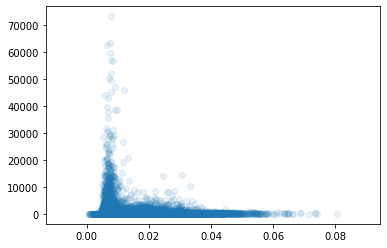

In [22]:
plt.scatter(kvs['mean'], kvs['count'], alpha=0.1)

In [27]:
kvs_lim = kvs.query('mean > 0.015') # param for this 0.015. How to choose?

In [32]:
good_ids = [dct.token2id[k] for k in kvs_lim.index]

In [33]:
len(good_ids)

8541

In [34]:
dct.filter_tokens(good_ids=good_ids)

In [35]:
len(dct)

8541

In [37]:
df = pd.DataFrame([(i, f) for i, f in dct.dfs.items()])
df = df.set_index(0)
df['token'] = df.apply(lambda x: dct[x.name], axis=1)

In [38]:
df = df.rename(columns={1: 'doc_frequency'})

(100, 5000)

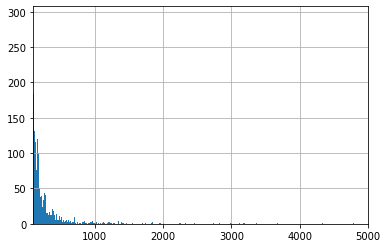

In [39]:
df['doc_frequency'].hist(bins=5000)
plt.xlim(no_below, 5000)

In [62]:
# dct.filter_extremes(no_below=5, no_above=0.5)
corpus = [dct.doc2bow(t) for t in tqdm(tokens)]

In [46]:
import sys
sys.path.append('../src/')
import topic_modeling as tm
from gensim.models.ldamodel import LdaModel

/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/_pytest/mark/structures.py:380: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)
/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is remov

In [47]:
topic_range = list(range(10, 100, 10))
tmodels_dir = Path('./tmodels')

import imp; imp.reload(tm)

<module 'topic_modeling' from '../src/topic_modeling.py'>

In [48]:
import imp; imp.reload(tm)
topic_range = [300]

In [49]:
df = tm.run_gensim_lda_mult_inner(
    topic_range,
    dct,
    tmodels_dir,
    c_measures=['u_mass', 'c_v'],
    corpus=corpus,
    texts=tokens,
)

  0%|          | 0/1 [00:00<?, ?it/s]
n_topics=300 | measure=u_mass:   0%|          | 0/1 [00:00<?, ?it/s]
n_topics=300 | measure=c_v:   0%|          | 0/1 [00:04<?, ?it/s]   
n_topics=300 | measure=c_v: 100%|██████████| 1/1 [02:42<00:00, 162.11s/it]


> /Users/abuonomo/code/DataSquad/astro2020/src/topic_modeling.py(475)get_coherence_df()
    474     import ipdb; ipdb.set_trace()
--> 475     df = pd.DataFrame(
    476         {



ipdb>  c


In [51]:
df

,model,n_topics,u_mass,c_v
0,gensim.models.ldamodel.LdaModel,300,-10.922588,0.431307


In [58]:
lda = LdaModel.load('tmodels/gensim_topic_model300')

In [61]:
lda